In [8]:
import jax

import jax.numpy as np
import jax.scipy as sp

import paragami

from numpy.polynomial.hermite import hermgauss

import matplotlib.pyplot as plt
%matplotlib inline

from bnpmodeling_runjingdev import result_loading_utils

from structure_vb_lib import structure_model_lib, posterior_quantities_lib, data_utils


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [3]:
data_file = '../data/thrush_data/thrush-data.str'
out_filename = 'thrush_fit'
out_folder = '../fits/thrush_fits/'

In [4]:
alpha0 = 3.0

# class with method to load all files from a particular perturbation

result_loader = result_loading_utils.FunctionalRefitsLoader(alpha0, 
                                                            out_folder, 
                                                            out_filename)

loading initial fit from:  ../fits/thrush_fits/thrush_fit_alpha3.0.npz
loading lr derivatives from:  ../fits/thrush_fits/thrush_fit_alpha3.0_lrderivatives.npz


# Load data

In [9]:
g_obs, _, labels, _ = data_utils.load_thrush_data(data_file)

loading thrush data from : 
../data/thrush_data/thrush-data.str


In [10]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]


# Load initial fit and its metadata

In [11]:
vb_init_free = result_loader.vb_init_free
vb_params_paragami = result_loader.vb_params_paragami
vb_init_dict = vb_params_paragami.fold(vb_init_free, free = True)

In [12]:
vb_init_free = vb_params_paragami.flatten(vb_init_dict, free = True)

In [13]:
print(vb_params_paragami)

OrderedDict:
	[pop_freq_dirichlet_params] = NumericArrayPattern (20, 7, 21) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (155, 19) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (155, 19) (lb=0.0, ub=inf)


In [15]:
# gauss-hermite parameters
gh_deg = int(result_loader.init_fit_meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)
    
# load prior parameters
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params(n_allele)

# set initial alpha
assert alpha0 == result_loader.init_fit_meta_data['dp_prior_alpha']
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)


{'dp_prior_alpha': 3.0, 'allele_prior_lambda_vec': DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1.], dtype=float64)}


# Define number of clusters

In [16]:
import bnpmodeling_runjingdev.exponential_families as ef
from bnpmodeling_runjingdev import cluster_quantities_lib  

In [17]:
seed = 2342
key = jax.random.PRNGKey(seed)

@jax.jit
def get_e_num_clusters(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return posterior_quantities_lib.get_e_num_clusters(g_obs, 
                                                       vb_params_dict,
                                                       gh_loc,
                                                       gh_weights, 
                                                       n_samples = 1000,
                                                       threshold = 0,
                                                       prng_key = key)

@jax.jit
def get_e_num_pred_clusters(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return posterior_quantities_lib.get_e_num_pred_clusters(vb_params_dict,
                                                       gh_loc,
                                                       gh_weights, 
                                                       n_samples = 1000,
                                                       threshold = 0,
                                                       prng_key = key)

### Thresholded

In [18]:
threshold1 = np.ceil(g_obs.shape[0] * g_obs.shape[1] * 0.01)
threshold2 = np.ceil(g_obs.shape[0] * 0.01)

@jax.jit
def get_e_num_clusters_thresh(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return posterior_quantities_lib.get_e_num_clusters(g_obs, 
                                                       vb_params_dict,
                                                       gh_loc,
                                                       gh_weights, 
                                                       n_samples = 1000,
                                                       threshold = threshold1,
                                                       prng_key = key)

@jax.jit
def get_e_num_pred_clusters_thresh(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return posterior_quantities_lib.get_e_num_pred_clusters(vb_params_dict,
                                                       gh_loc,
                                                       gh_weights, 
                                                       n_samples = 1000,
                                                       threshold = threshold2,
                                                       prng_key = key)

# expected allocations

In [19]:
@jax.jit
def get_e_num_ind(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_ind_per_cluster(vb_params_dict, 
                                                              gh_loc,
                                                              gh_weights)


@jax.jit
def get_e_num_loci(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_loci_per_cluster(g_obs, 
                                                               vb_params_dict,
                                                               gh_loc,
                                                               gh_weights)

### Function to make trace plot of expected allocations

In [20]:
def plot_e_num_obs_trace(vb_refit_list, lr_list, epsilon_vec): 
    
    # get arrays of mixture weights
    refit_array = result_loading_utils.get_post_stat_vec(get_e_num_ind, vb_refit_list)
    lr_array = result_loading_utils.get_post_stat_vec(get_e_num_ind, lr_list)
    
        
    fig, ax = plt.subplots(2, 4, figsize = (16, 6), sharex = True) 
    
    for k in range(8): 
        x0 = k // 4
        x1 = k % 4
        ax[x0, x1].plot(epsilon_vec, 
                       refit_array[:, k], 
                       '-o',
                       color = result_loading_utils.refit_color, 
                       label = 'refit')
        
        ax[x0, x1].plot(epsilon_vec, 
                       lr_array[:, k], 
                       '-o',
                       color = result_loading_utils.lr_color, 
                       label = 'lr')
        
        ax[x0, x1].set_title('k = {}'.format(k))
        
        if k == 0: 
            ax[x0, x1].legend()
            
    for k in range(4): 
        ax[-1, k].set_xlabel('epsilon')
        
    for k in range(2): 
        ax[k, 0].set_ylabel('E(# individuals)')
    
    fig.tight_layout()


# Function to plot results

In [21]:
def plot_results_for_perturbation(perturbation, delta): 
    
    #################
    # load free parameters
    #################
    vb_refit_list, lr_list, epsilon_vec = \
        result_loader.get_free_param_results_from_perturbation(perturbation, delta)
    assert (vb_refit_list[0] == lr_list[0]).all()
    
    #################
    # in-sample number of clusters
    #################
    fig, ax = plt.subplots(2, 3, figsize = (12, 6))
    # not-thresholded
    result_loading_utils.plot_post_stat_per_epsilon(get_e_num_clusters, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[0, 0])
    
    # thresholded
    result_loading_utils.plot_post_stat_per_epsilon(get_e_num_clusters_thresh, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[0, 1])
    ax[0, 0].set_title('in-sample; thresh = 0')
    ax[0, 1].set_title('in-sample; thresh = {}'.format(threshold1))
    ax[0, 0].legend()
    
    #################
    # predictive number of clusters
    #################
    result_loading_utils.plot_post_stat_per_epsilon(get_e_num_pred_clusters, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[1, 0])
    # thresholded
    result_loading_utils.plot_post_stat_per_epsilon(get_e_num_pred_clusters_thresh, 
                                                    vb_refit_list,
                                                    lr_list,
                                                    epsilon_vec,
                                                    ax[1, 1])
    ax[1, 0].set_title('predictive; thresh = 0')
    ax[1, 1].set_title('predictive; thresh = {}'.format(threshold2))
    fig.tight_layout();
        
    #################
    # expected number of loci per cluster
    #################
    result_loading_utils.\
        plot_mixture_weights(get_e_num_loci(vb_refit_list[-1]), 
                             get_e_num_loci(lr_list[-1]),
                             get_e_num_loci(lr_list[0]), 
                             ax[0, 2])
    ax[0, 2].set_yscale('log')
    ax[0, 2].set_title('e.num. obs per cluster')
    ax[0, 2].axhline(threshold1, color = 'grey')
    
    #################
    # expected number of individuals per cluster
    #################
    result_loading_utils.\
        plot_mixture_weights(get_e_num_ind(vb_refit_list[-1]), 
                             get_e_num_ind(lr_list[-1]),
                             get_e_num_ind(lr_list[0]), 
                             ax[1, 2])
    ax[1, 2].set_yscale('log')
    ax[1, 2].set_title('e.num. pred. obs per cluster')
    ax[1, 2].axhline(threshold2, color = 'grey')
    
    fig.tight_layout();
        
    # trace plot of mixture weights 
    plot_e_num_obs_trace(vb_refit_list, lr_list, epsilon_vec)


# Sigmoidal perturbations

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.300350e-07
  warnings.warn(


Optim time at epsilon = 1: 6.006secs
Derivative time: 0.521secs


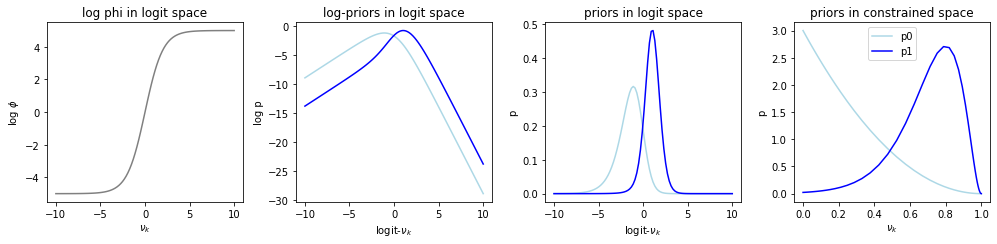

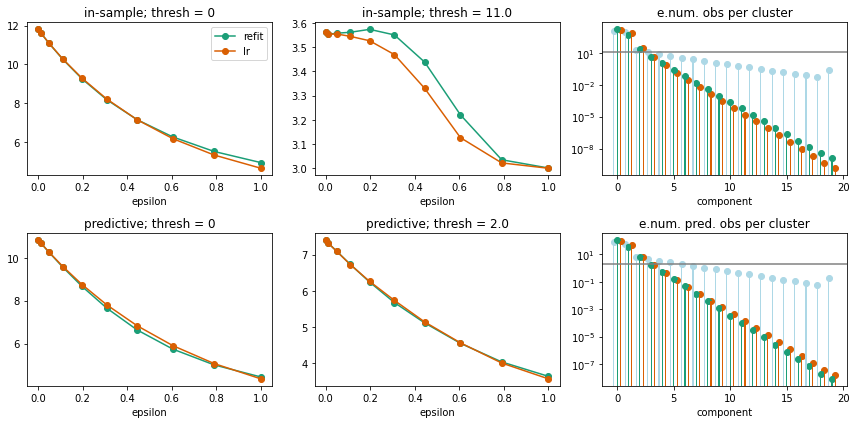

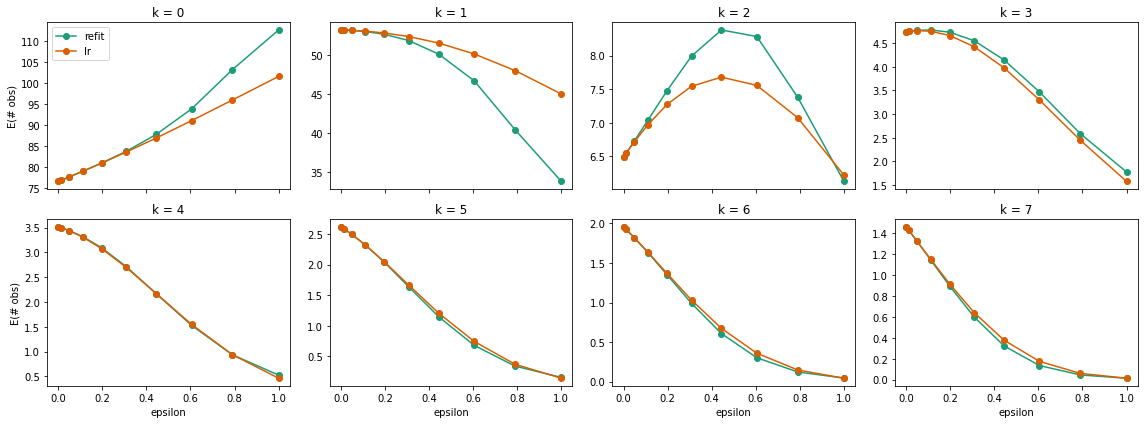

In [22]:
delta = 5
perturbation = 'sigmoidal'

result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, 
                              delta)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.735899e-07
  warnings.warn(


Optim time at epsilon = 1: 9.875secs
Derivative time: 0.521secs


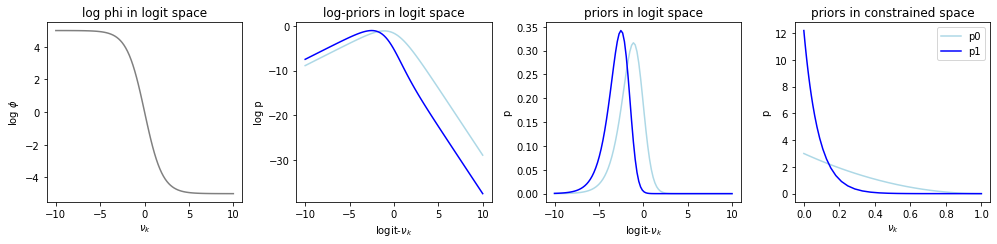

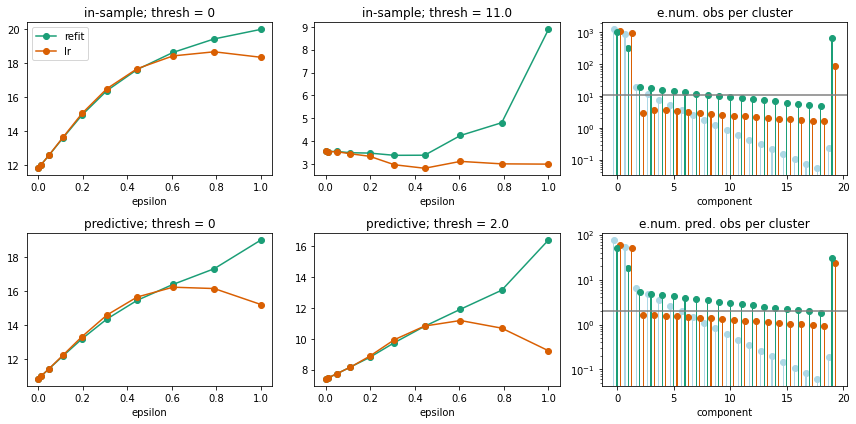

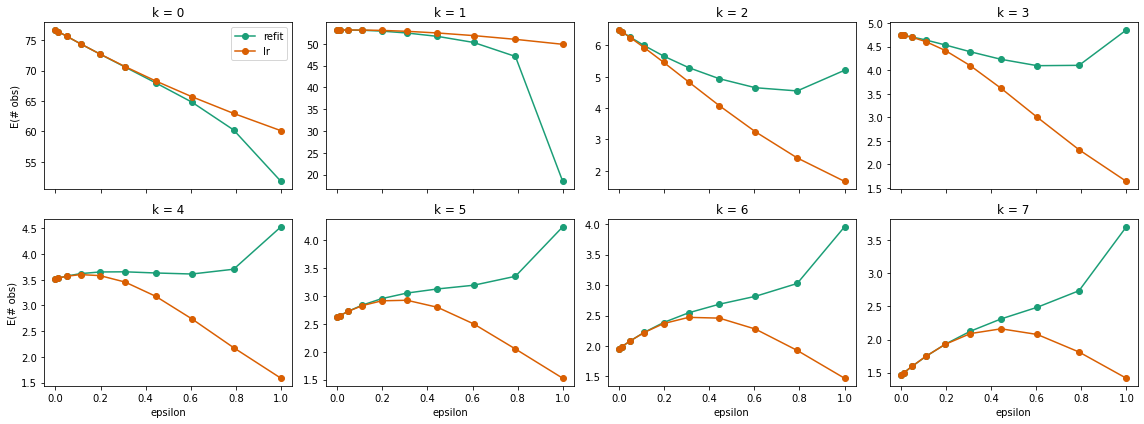

In [23]:
perturbation = 'sigmoidal'
delta = -5
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta)

# Perturbing the alpha parameter upwards 
## (using a functional perturbation)

Optim time at epsilon = 1: 5.848secs
Derivative time: 0.605secs


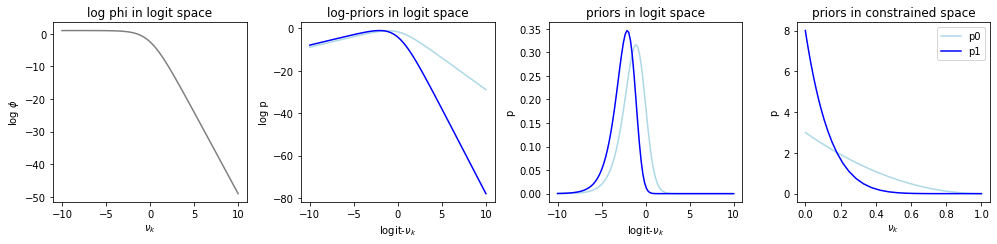

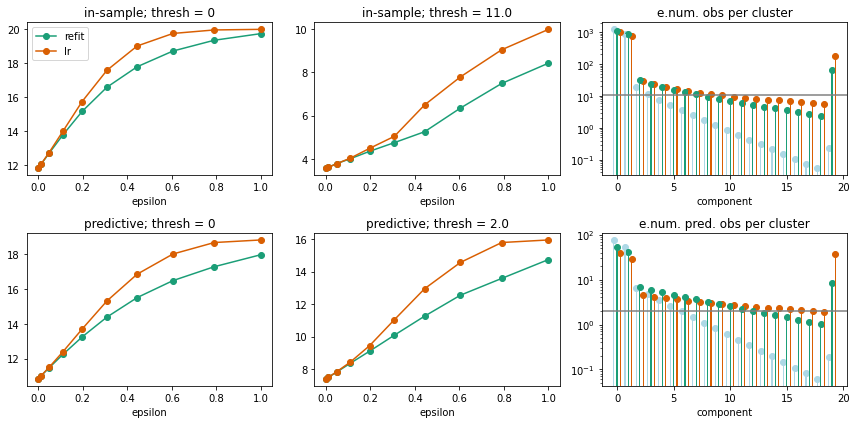

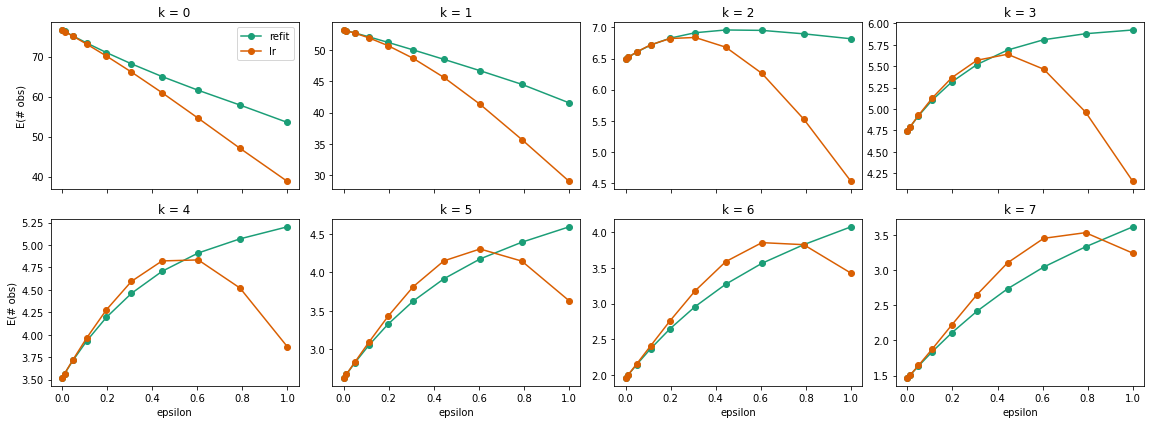

In [24]:
perturbation = 'alpha_pert_pos'
delta = 1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta)

# Perturb alpha parameter downwards

In [26]:
# perturbation = 'alpha_pert_neg'
# delta = 1
# result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
# plot_results_for_perturbation(perturbation, delta)

# flip alpha perturbation along x-axis

In [27]:
# plot_stuff('alpha_pert_pos_xflip', delta = 1);

In [28]:
# plot_stuff('alpha_pert_neg_xflip', delta = 1);

# Perturb with Gaussian bumps

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.453183e-06
  warnings.warn(


Optim time at epsilon = 1: 8.098secs
Derivative time: 0.620secs


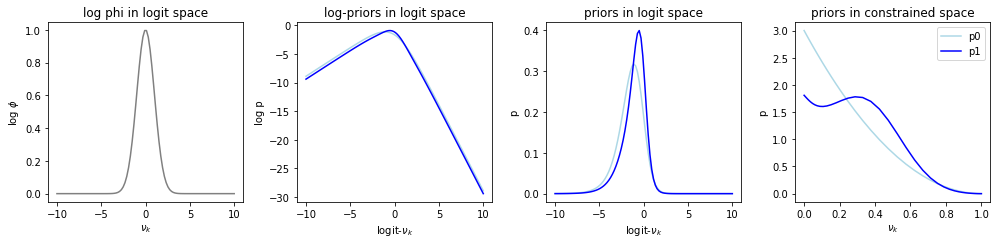

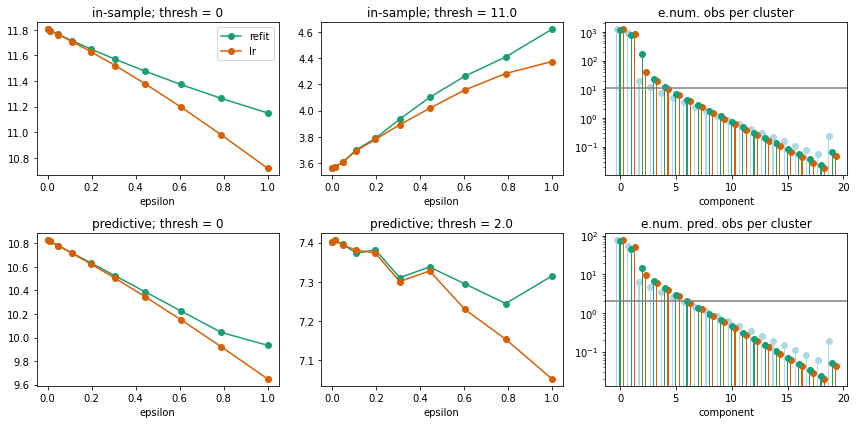

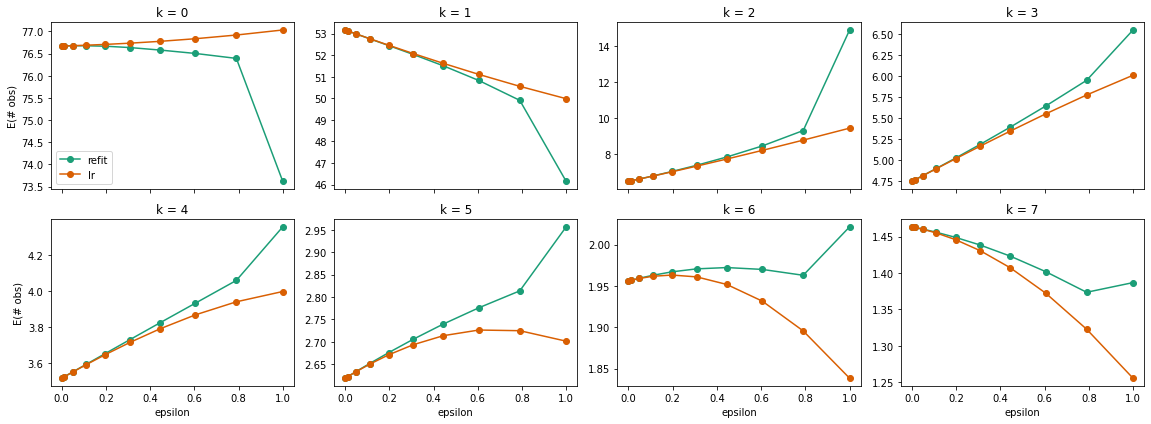

In [29]:
perturbation = 'gauss_pert1'
delta = 1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta)

Optim time at epsilon = 1: 5.425secs
Derivative time: 0.620secs


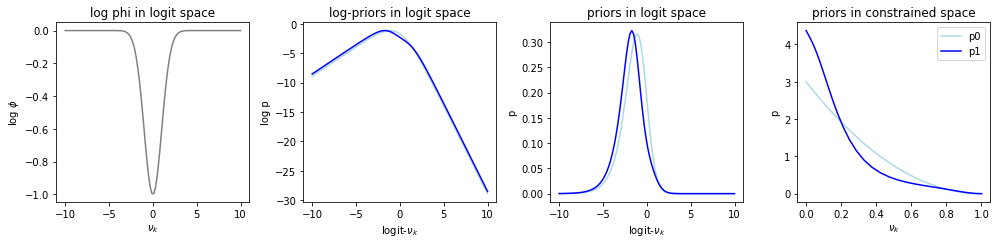

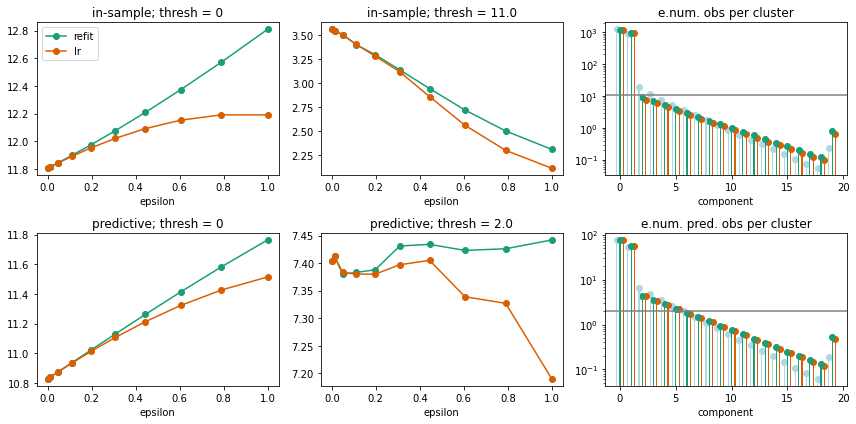

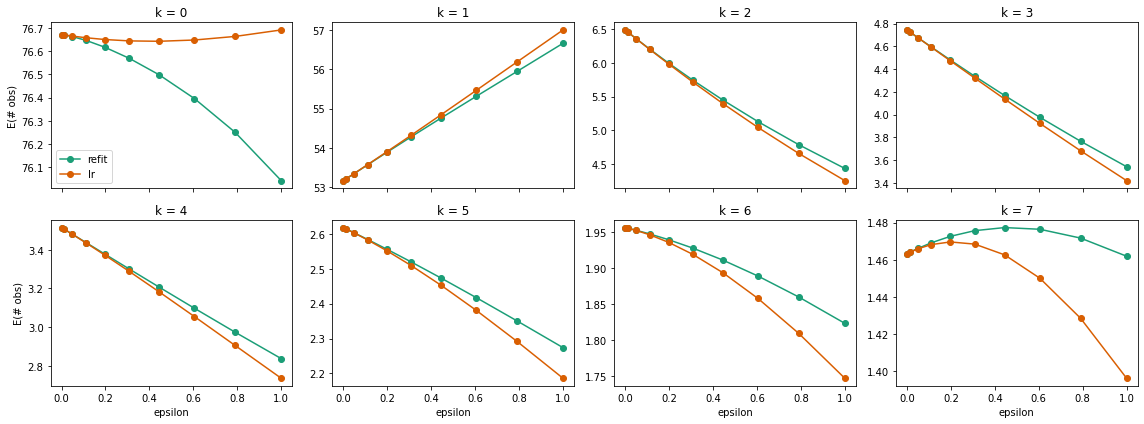

In [30]:
perturbation = 'gauss_pert1'
delta = -1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.565685e-07
  warnings.warn(


Optim time at epsilon = 1: 6.861secs
Derivative time: 0.703secs


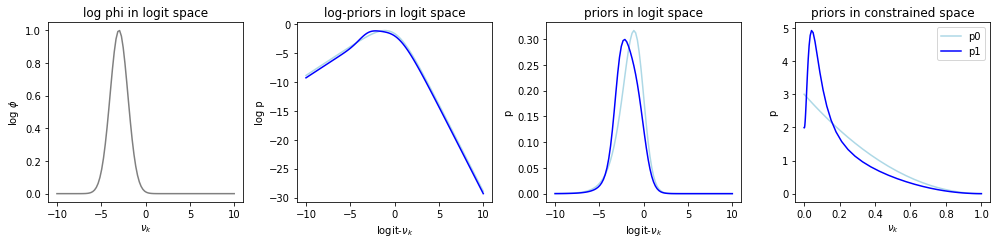

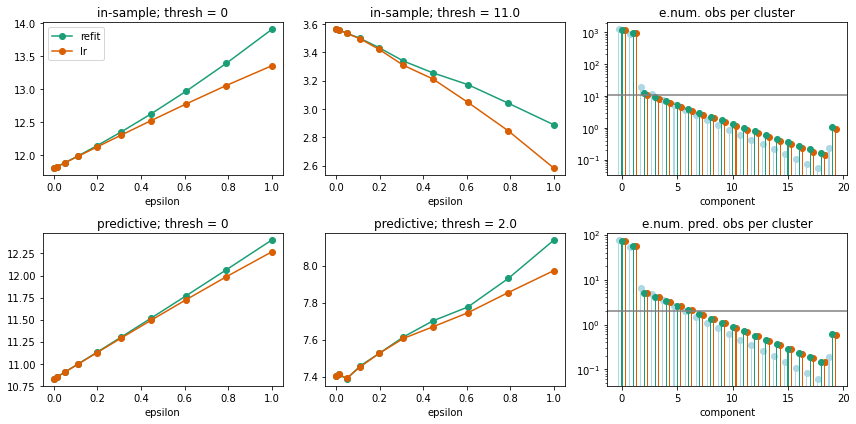

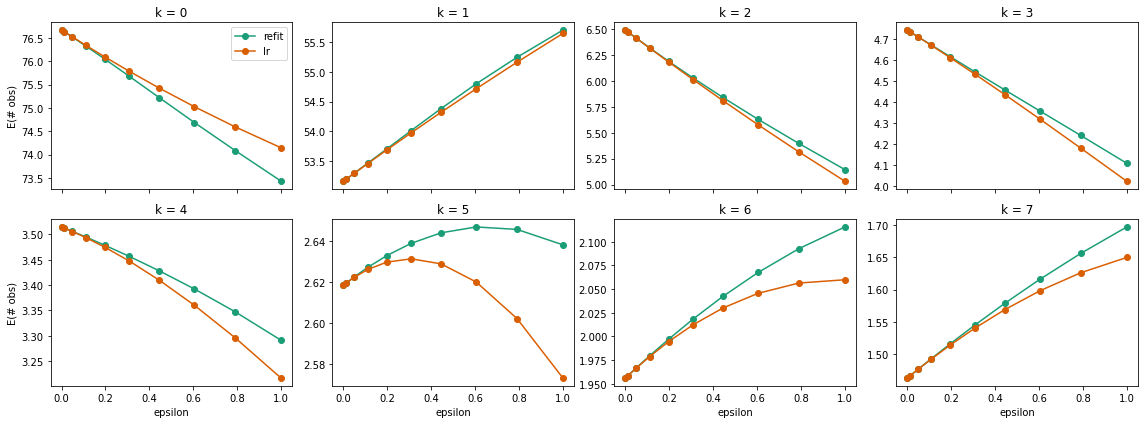

In [31]:
perturbation = 'gauss_pert2'
delta = 1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.349213e-08
  warnings.warn(


Optim time at epsilon = 1: 7.159secs
Derivative time: 0.703secs


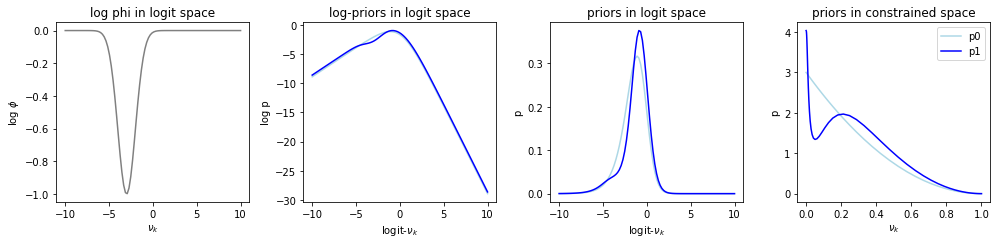

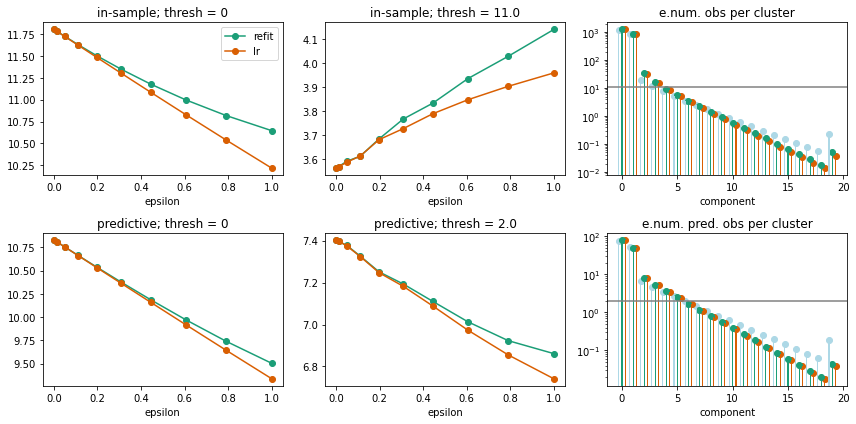

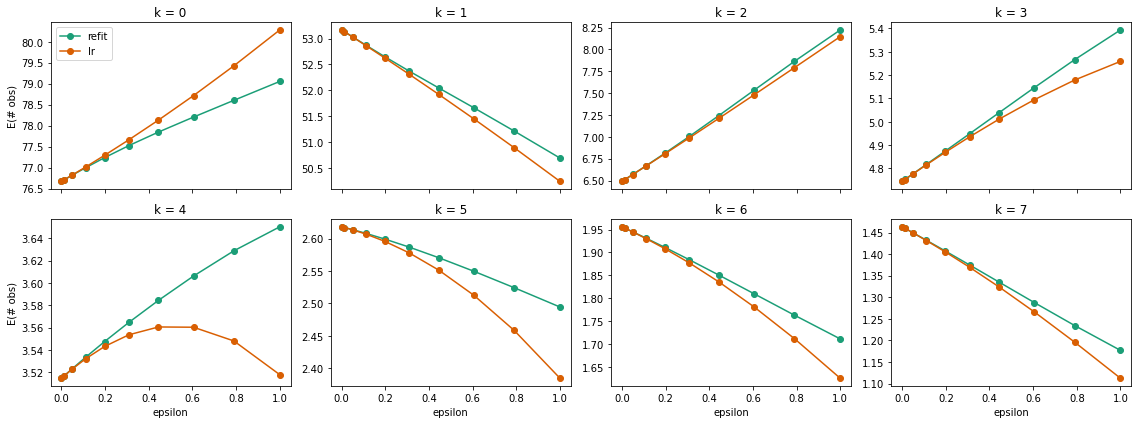

In [32]:
perturbation = 'gauss_pert2'
delta = -1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta)